# Streaming Training Tweets Using Tweepy

[Tweepy](https://www.tweepy.org) is a python wrapper for the [Twitter API](https://developer.twitter.com/en/docs) that allowed our team to easily collect tweets in real-time and store them in [MongoBD](https://www.mongodb.com). The below script was run on macOS with 6 GiB of storage for roughly 10 hours. By filtering based on location, I only received geotagged tweets with a known location to use for training the model. I didn't retrieve data from oceania countries because there is a error called 406 when I run my code. You can fine the bounding boxes of each country [here.](https://gist.github.com/graydon/11198540). After collecting data from the golbal, we found that the dataset among 10 countries are extreme inbalance. Therefore, we are going to collect more records from the least 8 countries.

In [32]:
import tweepy
import json
from pymongo import MongoClient

class StreamListener(tweepy.StreamListener):
    """tweepy.StreamListener is a class provided by tweepy used to access
    the Twitter Streaming API to collect tweets in real-time.
    """

    def on_connect(self):
        """Called when the connection is made"""
        
        print("You're connected to the streaming server.")

    def on_error(self, status_code):
        """This is called when an error occurs"""
        
        print('Error: ' + repr(status_code))
        return False

    def on_data(self, data):
        """This will be called each time we receive stream data"""
        
        client = MongoClient()

        # I stored the tweet data in a database called 'training_tweets' in MongoDB, if 
        # 'training_tweets' does not exist it will be created for you.
        db = client.training_tweets

        # Decode JSON
        datajson = json.loads(data)

        # I'm only storing tweets in English. I stored the data for these tweets in a collection 
        # called 'training_tweets_collection' of the 'training_tweets' database. If 
        # 'training_tweets_collection' does not exist it will be created for you. 
        if "lang" in datajson:
            db.training_tweets_collection.insert_one(datajson)


if __name__ == "__main__":

    # These are provided to you through the Twitter API after you create a account
    consumer_key = "owL3x8WeEke0BCHCQHUvEykKv"
    consumer_secret = "gam4Ha8K2UOOgisXxSIU35vAnmNR0DXDm2ILtnOJsROOIOPyVY"
    access_token = "1225979021344878594-B2jw0KZO5xDddPV5Vn8sQOuOvfCzwc"
    access_token_secret = "Ir0Lg9rwBzFTZd0Zy62Lb3sE14SrrjYdIKBeqoNB5OXUt"

    auth1 = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth1.set_access_token(access_token, access_token_secret)

    # LOCATIONS are the longitude, latitude coordinate corners for a box that restricts the 
    # geographic area from which you will stream tweets. The first two define the southwest
    # corner of the box and the second two define the northeast corner of the box. 
    #LOCATIONS = [-180,-90,180,90]        # read all the stream around the world  
    LOCATIONS = [#129.408463169, 31.0295791692, 145.543137242, 45.5514834662,        # japan
                #-7.57216793459, 49.959999905, 1.68153079591, 58.6350001085,         # UK
                95.2930261576, -10.3599874813, 141.03385176, 5.47982086834,         # Indonesia
                26.0433512713, 35.8215347357, 44.7939896991, 42.1414848903,         # Turkey
                #68.1766451354, 7.96553477623, 97.4025614766, 35.4940095078,         # India
                -73.4154357571, -55.25, -53.628348965, -21.8323104794,              # Argentina
                -117.12776, 14.5388286402, -86.811982388, 32.72083,                 # Mexico
                34.6323360532, 16.3478913436, 55.6666593769, 32.161008816]          # Saudi Arabia    
    
    
    #LOCATIONS = [-7.57216793459, 49.959999905, 1.68153079591, 58.6350001085]       
    #LOCATIONS = [95.2930261576, -10.3599874813, 141.03385176, 5.47982086834]       
    #LOCATIONS = [26.0433512713, 35.8215347357, 44.7939896991, 42.1414848903]       
    #LOCATIONS = [68.1766451354, 7.96553477623, 97.4025614766, 35.4940095078]       # India
    #LOCATIONS = [-73.4154357571, -55.25, -53.628348965, -21.8323104794]            # Argentina
    #LOCATIONS = [-117.12776, 14.5388286402, -86.811982388, 32.72083]               # Mexico
    #LOCATIONS = [34.6323360532, 16.3478913436, 55.6666593769, 32.161008816]        # Saudi Arabia
    
    
    

    stream_listener = StreamListener(api=tweepy.API(wait_on_rate_limit=True))
    stream = tweepy.Stream(auth=auth1, listener=stream_listener)
    stream.filter(locations=LOCATIONS)

You're connected to the streaming server.


KeyboardInterrupt: 

In [11]:
import tweepy 

# Fill the X's with the credentials obtained by 
# following the above mentioned procedure. 
consumer_key = "owL3x8WeEke0BCHCQHUvEykKv"
consumer_secret = "gam4Ha8K2UOOgisXxSIU35vAnmNR0DXDm2ILtnOJsROOIOPyVY"
access_token = "1225979021344878594-B2jw0KZO5xDddPV5Vn8sQOuOvfCzwc"
access_token_secret = "Ir0Lg9rwBzFTZd0Zy62Lb3sE14SrrjYdIKBeqoNB5OXUt"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
media_files = set()
for status in tweepy.Cursor(api.home_timeline,screen_name='realDonaldTrump').items(100):
    media = status.entities.get('media', [])
    if(len(media) > 0):
            media_files.add(media[0]['media_url'])
            url=status._json['media_url']
            print(url)



TweepError: Twitter error response: status code = 429

# Feature Selection, Feature Engineering, and Data Cleaning

## Feature Selection

### Top 10 Countries

At the end of 10 hours I had collected data from over 1.7 million records from over 211 counties. After meeting with sponsors, we are going to filter top 10 countries to continue our project.

In [1]:
from pymongo import MongoClient

# creation of MongoClient  
client = MongoClient()  
    
# Connect with the portnumber and host  
client = MongoClient("mongodb://localhost:27017/")  
    
# Access database  
db = client.training_tweets  
    
# Access collection of the database  
dbc = db.training_tweets_collection 

agg_result = dbc.aggregate( 
    [{ 
    "$group" :  
        {"_id" : "$place.country_code",   
         "total" : {"$sum" : 1} 
         }},
    {"$sort" : {"total": -1}},
    {"$limit": 10}
        
    ]) 
for i in agg_result: 
    print(i) 

{'_id': 'US', 'total': 544974}
{'_id': 'BR', 'total': 368761}
{'_id': 'JP', 'total': 75792}
{'_id': 'GB', 'total': 65501}
{'_id': 'AR', 'total': 55712}
{'_id': 'MX', 'total': 42743}
{'_id': 'TR', 'total': 41334}
{'_id': 'IN', 'total': 39458}
{'_id': 'SA', 'total': 38217}
{'_id': 'ID', 'total': 32521}


{'_id': 'US', 'total': 544974}

{'_id': 'BR', 'total': 368761}

{'_id': 'JP', 'total': 75792}

{'_id': 'GB', 'total': 65501}

{'_id': 'AR', 'total': 55712}

{'_id': 'MX', 'total': 42743}

{'_id': 'TR', 'total': 41334}

{'_id': 'IN', 'total': 39458}

{'_id': 'SA', 'total': 38217}

{'_id': 'ID', 'total': 32521};

---

{'_id': 'US', 'total': 1221829}

{'_id': 'BR', 'total': 642391}

{'_id': 'JP', 'total': 285534}

{'_id': 'GB', 'total': 163041}

{'_id': 'IN', 'total': 143438}

{'_id': 'ID', 'total': 119988}

{'_id': 'TR', 'total': 117828}

{'_id': 'AR', 'total': 105199}

{'_id': 'ES', 'total': 92252}

{'_id': 'PH', 'total': 87299}

---

{'_id': 'JP', 'total': 332293}

{'_id': 'US', 'total': 213869}

{'_id': 'GB', 'total': 153675}

{'_id': 'IN', 'total': 153034}

{'_id': 'ID', 'total': 122714}

{'_id': 'AR', 'total': 105584}

{'_id': 'TR', 'total': 97441}

{'_id': 'MX', 'total': 86646}

{'_id': 'SA', 'total': 66391}

{'_id': 'MY', 'total': 57450}

In [7]:
#this code is for former dataset
# dbc1 = dbc.delete_many({"place.country_code":{"$nin": 
#                                ["US","BR","JP","GB","AR","MX","TR","IN","SA","ID"]}}
#              )

# create 'country_code' : 'other' dataset
dbc1 = dbc.delete_many({"place.country_code":{"$in": 
                               ["US","BR","JP","GB","AR","MX","TR","IN","SA","ID"]}}
             )

#print(dbc1.deleted_count, "documents delete")

# this code is for the new dataset

# dbc1 = dbc.delete_many({"place.country_code":{"$nin": 
#                                 ["ID","TR","AR","MX","SA"]}}
#               )

#print(dbc1.deleted_count, "documents delete")



164175 documents delete

Let's check our collections after deleting some unmatched records.

In [8]:
#dbc.distinct("place.country_code")
#dbc.distinct("lang").
#dbc.find_one()

{'_id': ObjectId('5f6a311d76e9900d03747ea7'),
 'created_at': 'Tue Sep 22 17:15:04 +0000 2020',
 'id': 1308454780365406213,
 'id_str': '1308454780365406213',
 'text': 'Just posted a video @ My Happy Place https://t.co/oFz8AHujAc',
 'source': '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 2734192486,
  'id_str': '2734192486',
  'name': '@bespokeluxurysuits',
  'screen_name': 'bespokesuitske',
  'location': 'Nairobi, Kenya',
  'url': 'https://www.instagram.com/bvg_kenya/',
  'description': 'Dealers In:\n°WeddingSuits👔\n\n°Official & CasualWear👔👖\n\nEmail:\n(Bespokeluxurysuits@gmail.com)\nWhattsapp\n\n+254707965013\n\n WORLDWIDE SHIPPING\n✈✈✈✈✈✈✈\n\n#wesuityou',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 46,
  'friends_count'

['ID', 'BR', 'TR', 'IN', 'SA', 'US', 'GB', 'MX', 'JP', 'AR'];

---

['BR', 'US', 'GB', 'JP', 'AR', 'TR', 'ID', 'IN']

---

['MX', 'ID', 'JP', 'GB', 'SA', 'TR', 'AR', 'IN']

---

['ID', 'TR', 'MX', 'AR', 'SA']

In [9]:
dbc.count_documents({})

404126

Now we have 2799248 records that only belong to the top 10 contries.

### Profile Banner URL

In [10]:
dbc.count_documents({ "user.profile_banner_url": { "$exists": "true" } })

363203

In [11]:
dbc.count_documents({ "user.profile_image_url_https": { "$exists": "true" } })

2799248

There are 2504849 documents having profile banner urls. All of documents have profile image urls. I use the command `db.training_tweets_collection.remove({"user.profile_banner_url":{"$exists": false}})` in terminal to remove documents without the given field. The result is `WriteResult({ "nRemoved" : 294399 })`.

In [11]:
dbc.count_documents({})

363203

Now, we have 2,504,849 records.

### Fields

In addition to the tweet itself, the API provides a number of other fields, these are the fields I used to build the model:

| Field | Type | Description |
|-------|------|-------------|
|'text'	| String | The actual UTF-8 text of the tweet |
|'country_code'| String | Country code representing the country that tweet was sent from |
| coordinates' | Array of Float | A series of longitude and latitude points that define a bounding box from where the tweet was sent |
| 'screen_name' | String | The screen name chosen by the user |
'favourites_count'| Int | The number of tweets this user has liked in the account’s lifetime |
| 'followers_count' | Int | The number of followers the user currently has |
| 'statuses_count' | Int |	The number of tweets (including retweets) issued by the user |
| 'friends_count' | Int	| The number of users the user is following (AKA their “followings”) |
| 'listed_count' |	Int	| The number of public lists the user is a member of |
| 'profile_image_url_https' | String | A HTTPS-based URL pointing to the user’s profile image |
| 'profile_banner_url' | String | The HTTPS-based URL pointing to the standard web representation of the user’s uploaded profile banner |

To pull these fields I first exported the data from MongoDB as a json file:
`mongoexport --db training_tweets --collection training_tweets_collection --out training_tweets.json`. I then converted training_tweets.json to a csv file and pulled only the fields from the table above.

In [12]:
import json
import unicodecsv as csv    # unicodecsv ensures that emojis are preserved

def tweets_json_to_csv(file_list, csv_output_file):
    '''
    INPUT: list of JSON files
    OUTPUT: single CSV file
    
    Takes a list of JSON files containing tweets and associated metadata and reads each file
    line by line, parsing the revelent fields, and writing it to a CSV file.
    '''
    

    count = 0
    f = csv.writer(open(csv_output_file, "wb+"))
    
    # Column names
    f.writerow(['tweet',                    # relabelled: the API calls this 'text'
                'country_code', 
                'bounding_box', 
                'screen_name',
                'favourites_count', 
                'followers_count', 
                'statuses_count', 
                'friends_count',
                'listed_count', 
                'image_url',               # relabelled: the API calls this 'profile_image_url_https'
                'banner_url'
                ])             # relabelled: the API calls this 'profile_banner_url'

    for file_ in file_list:
        with open(file_, "r") as r:
            for line in r:
                try:
                    tweet = json.loads(line)
                except:
                    continue
                if tweet and tweet['place'] != None:
                    f.writerow([tweet['text'],                                    
                                tweet['place']['country_code'],                                        
                                tweet['place']['bounding_box']['coordinates'],    
                                tweet['user']['screen_name'],                    
                                tweet['user']['favourites_count'],                
                                tweet['user']['followers_count'],                 
                                tweet['user']['statuses_count'],                  
                                tweet['user']['friends_count'],                 
                                tweet['user']['listed_count'],                                                             
                                tweet['user']['profile_image_url_https'],
                                tweet['user']['profile_banner_url']
                                ])                   
                    count += 1
                    
                    # Status update
                    if count % 100000 == 0:
                        print ('Just stored tweet #{}'.format(count))
                        
if __name__ == "__main__":
    
    tweets_json_to_csv(['training_tweets.json'], 'training_tweets.csv')

Just stored tweet #100000
Just stored tweet #200000
Just stored tweet #300000


From this point forward I was able to read and manipulate the csv file as a pandas DataFrame:

In [13]:
import pandas as pd

# 'utf-8' ensures that emojis are preserved 

df = pd.read_csv('training_tweets.csv', encoding='utf-8')

## Feature Engineering


### 'centroid'

Instead of providing the exact latitude and longitude of the tweet, the Twitter API provides a polygonal bounding box of coordinates that encloses the place where the tweet was sent. To facilitate plotting the tweets on a map and other functions, I found the centroid of each bounding box:


In [14]:
def find_centroid(row):
    
    '''
    Helper function to return the centroid of a polygonal bounding box of longitude, latitude coordinates
    '''
    
    try:
        row_ = eval(row)
        lst_of_coords = [item for sublist in row_ for item in sublist]
        longitude = [p[0] for p in lst_of_coords]
        latitude = [p[1] for p in lst_of_coords]
        return (sum(latitude) / float(len(latitude)), sum(longitude) / float(len(longitude)))
    except:
        return None
        
# Create a new column called 'centroid' 

df['centroid'] = list(map(lambda row: find_centroid(row), df['bounding_box']))


`map()` will return a map object in Python 3+, more details [here.](https://stackoverflow.com/questions/1303347/getting-a-map-to-return-a-list-in-python-3-x)


Using the centroids I was able to generate the map on the left from the training tweets using the Matplotlib Basemap Toolkit

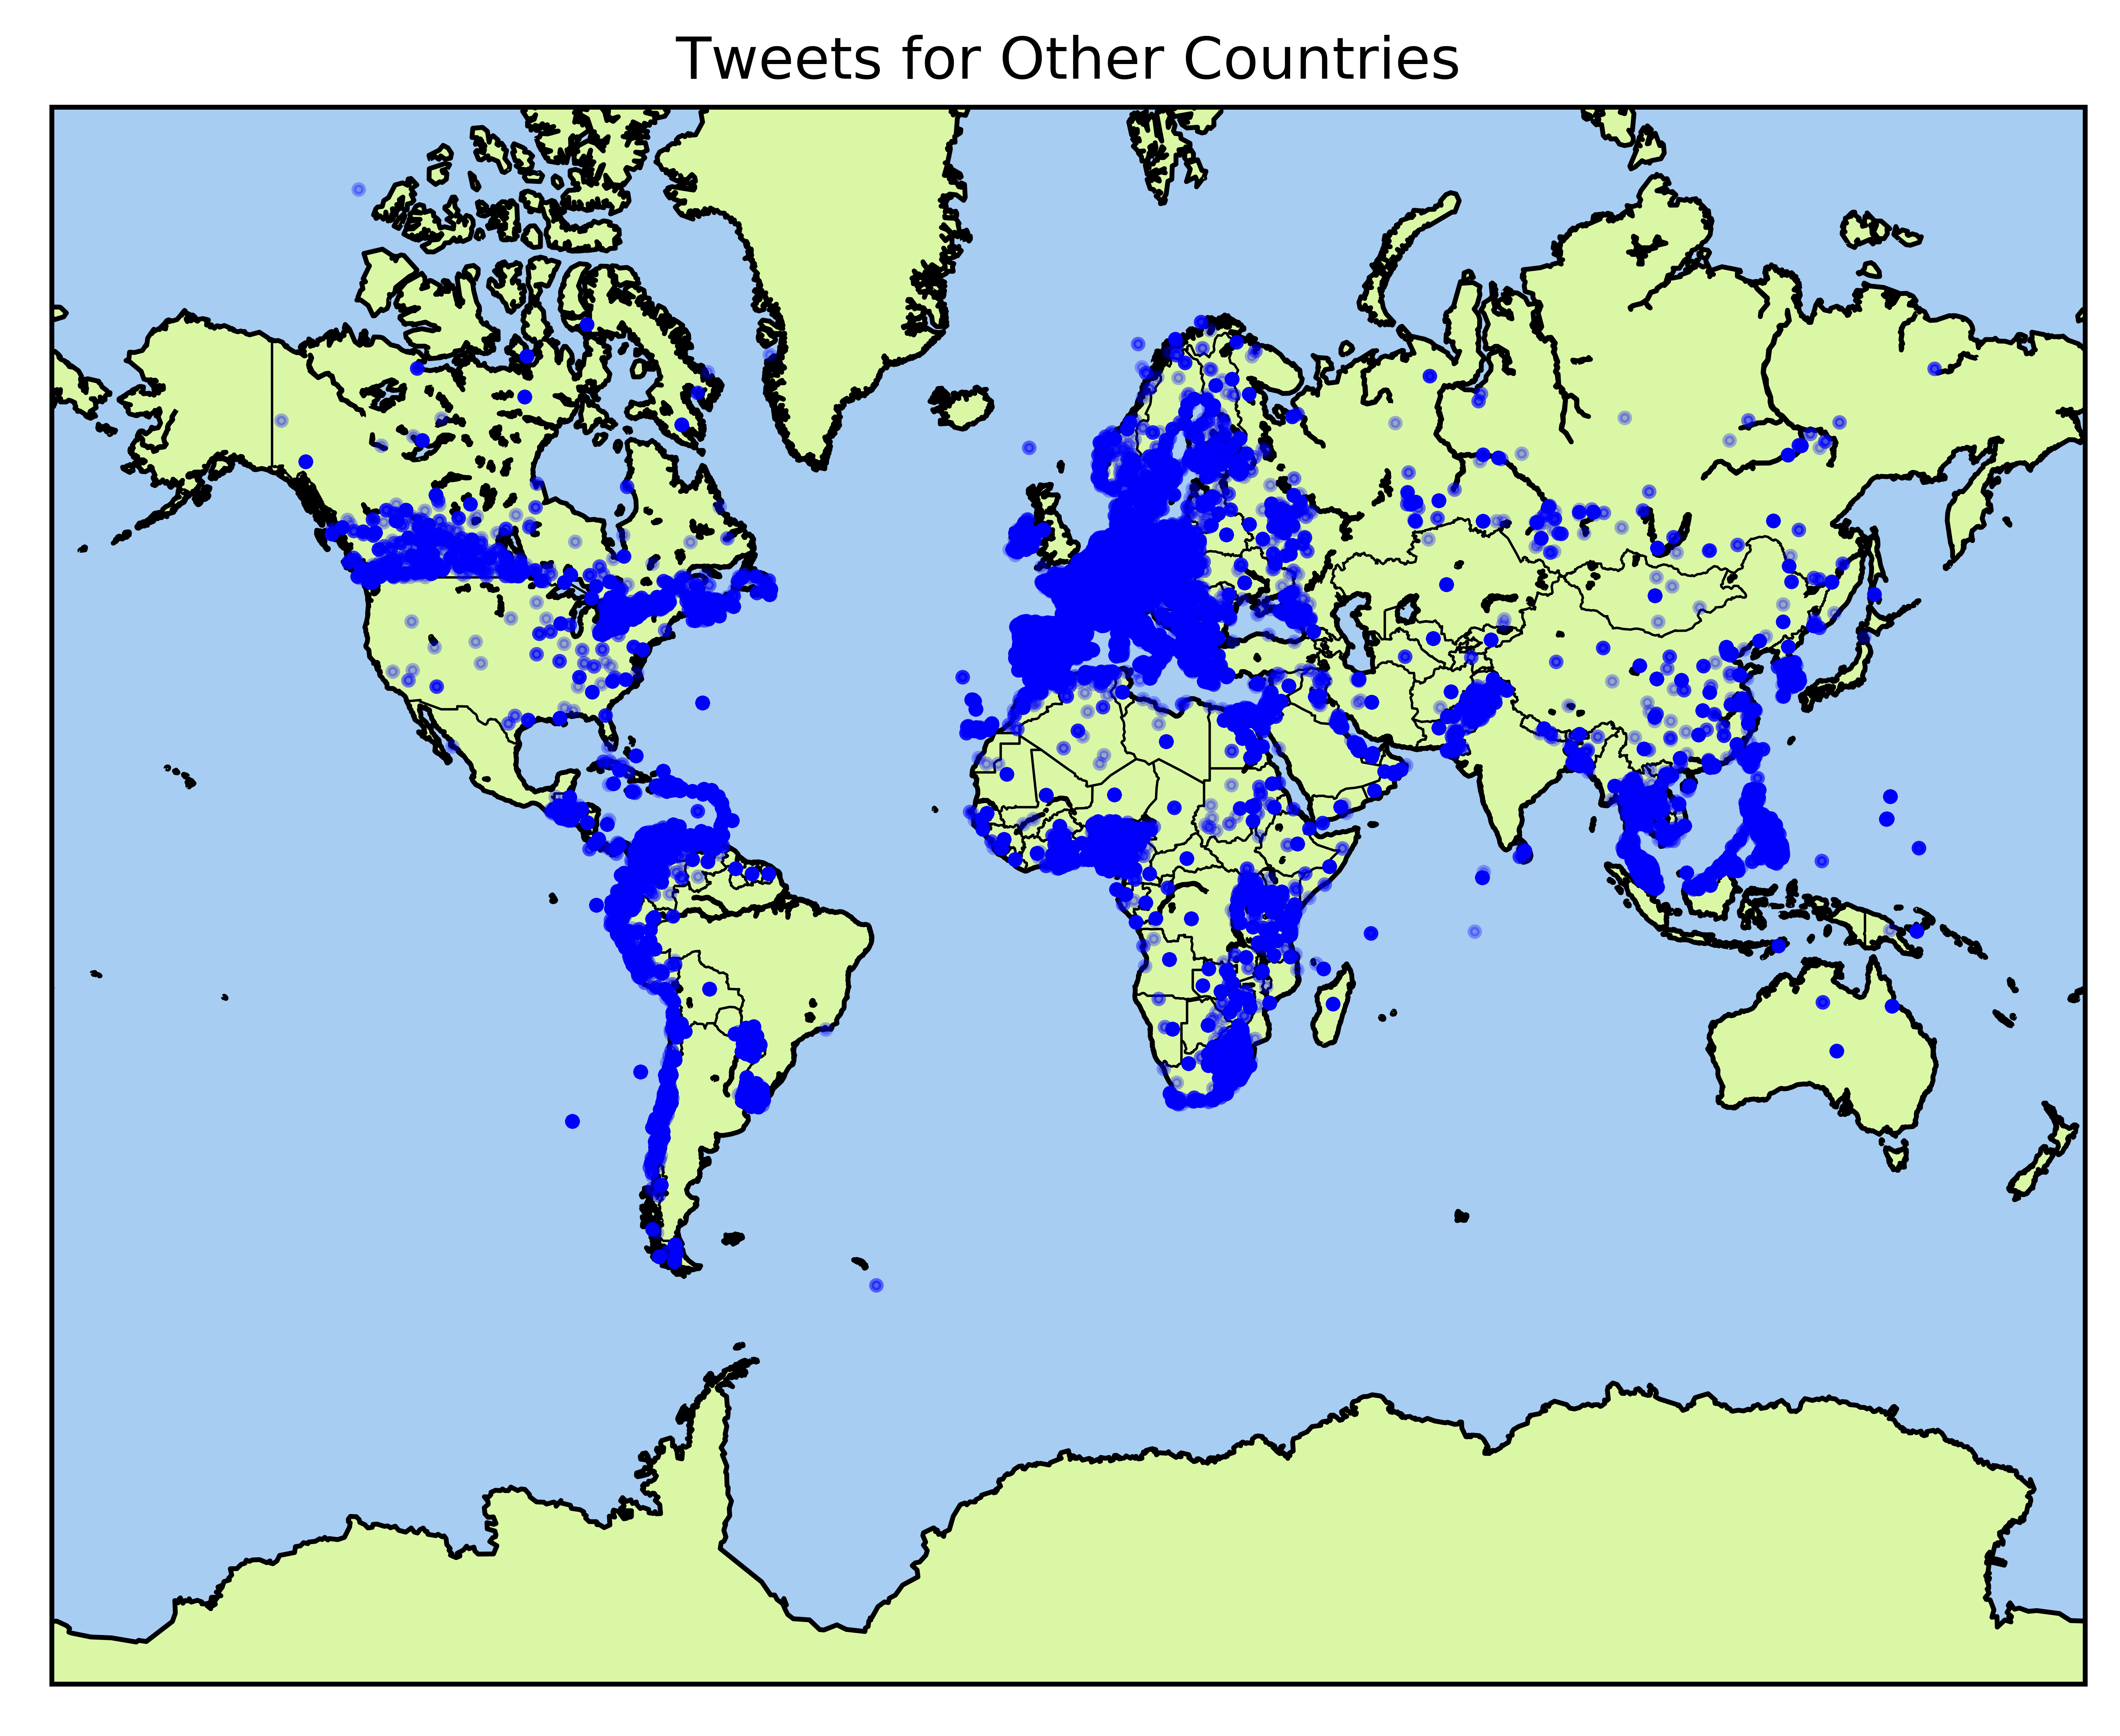

In [17]:
# Address KeyError: 'PROJ_LIB'
# import os
# import conda

# conda_file_dir = conda.__file__
# conda_dir = conda_file_dir.split('lib')[0]
# proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
# os.environ["PROJ_LIB"] = proj_lib

# import package
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

#map size
plt.figure(figsize=(12,6), dpi=1000)

# Declare map projection, size and resolution
map = Basemap(projection='merc',
              llcrnrlat=-80,
              urcrnrlat=80,
              llcrnrlon=-180,
              urcrnrlon=180,
              lat_ts=20,
              resolution='l')

# set lon and lat   
lon = list(df['centroid'].str[1])
lat = list(df['centroid'].str[0])
    
x,y = map(lon,lat)

# plot map
map.plot(x, y, 'bo', markersize=2, alpha=.3)
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = '#DAF7A6', lake_color='#a7cdf2')
map.drawmapboundary(fill_color='#a7cdf2')

# set a title
plt.title("Tweets for Other Countries")

# Display map
plt.show()

## Data Cleaning

### Missing Data

A small percentage of tweets contained missing values for 'country_code.' When this occurred, or other missing data occurred, I chose to drop the entire row:

In [18]:
df['country_code'].dropna(axis=0, inplace=True)

### Delete Duplicate Users

During the 10 hours collection period many users tweeted more than once. To prevent potential leakage I deleted the duplicate tweets by user ('screen_name').



In [18]:
df = df.drop_duplicates(subset = ["screen_name"])

In [19]:
len(df)

120241

Now we get 360750 of 1182355 records which are prepared for our analysis.

TR    41503

ID    38425

MX    27073

AR    26432

SA    25019

### Image URL

I am going to remove the `_normal` character at the end of the URL. This is the [method](https://stackoverflow.com/questions/28986489/how-to-replace-text-in-a-column-of-a-pandas-dataframe).

In [20]:
df['image_url'] = df['image_url'].str.replace('_normal','')

In [28]:
#delete country_code column and add a new column with new value
# del df['country_code']
# df.insert(1, 'country_code', 'OTHER')
df['country_name'] = df['country_code'].map({'OTHER':'Other Countries'})
df

,tweet,country_code,bounding_box,screen_name,favourites_count,followers_count,statuses_count,friends_count,listed_count,image_url,banner_url,centroid,country_name
0,Origami pio se cerró o que?,OTHER,"[[[-57.674304, -25.34793], [-57.674304, -25.25...",aguero_cyn,4365,248,3869,591,0,https://pbs.twimg.com/profile_images/130590397...,https://pbs.twimg.com/profile_banners/14660583...,"(-25.300264000000002, -57.6060175)",Other Countries
1,Oh some other scrote was there too but I forge...,OTHER,"[[[2.491449, 48.829471], [2.491449, 48.857306]...",judeinlondon2,37800,12626,112123,857,52,https://pbs.twimg.com/profile_images/130636945...,https://pbs.twimg.com/profile_banners/53641804...,"(48.8433885, 2.5045314999999997)",Other Countries
2,@_Didintle_m Again ?,OTHER,"[[[28.272246, -26.23152], [28.272246, -26.0681...",Mtubane,66235,23184,96185,17372,2,https://pbs.twimg.com/profile_images/130623093...,https://pbs.twimg.com/profile_banners/23651766...,"(-26.149857, 28.3586025)",Other Countries
3,@staaSTALLIONS Your donation matters this week...,OTHER,"[[[-54.172648, 48.12193], [-54.172648, 48.2497...",LifelineNL,905,1223,8915,675,35,https://pbs.twimg.com/profile_images/104756255...,https://pbs.twimg.com/profile_banners/19412621...,"(48.1858595, -54.0514935)",Other Countries
4,@Tashevich Яндекс Российская-Премьер Лига + ве...,OTHER,"[[[36.887816, 55.488324], [36.887816, 56.02125...",Mosfilmovskiy,37162,13208,49932,558,114,https://pbs.twimg.com/profile_images/127337269...,https://pbs.twimg.com/profile_banners/97252340...,"(55.7547875, 37.4276425)",Other Countries
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362983,มองหน้าอยากโดนเสียบอ่อ 5555+ 🗡️🗡️😁😁 #สาวสอง #ก...,OTHER,"[[[100.720708, 14.028511], [100.720708, 14.060...",Nannapa72412587,69,672,149,59,0,https://pbs.twimg.com/profile_images/130475611...,https://pbs.twimg.com/profile_banners/12771211...,"(14.044491500000001, 100.7324405)",Other Countries
362984,Cuando las empresas @ClaroPeru estafan a los u...,OTHER,"[[[-77.122193, -11.947141], [-77.122193, -11.8...",TecMedia2,345,35,709,270,0,https://pbs.twimg.com/profile_images/101415959...,https://pbs.twimg.com/profile_banners/10141590...,"(-11.876194, -77.086455)",Other Countries
362985,Y al final del día lo termino de lograr...\nMe...,OTHER,"[[[-74.483289, 3.717432], [-74.483289, 4.80713...",alexita9803,2864,77,760,248,0,https://pbs.twimg.com/profile_images/129937998...,https://pbs.twimg.com/profile_banners/61265911...,"(4.2622835, -74.243671)",Other Countries
362990,@Juan49542640 @defcondeux @kieroirmeamarte Que...,OTHER,"[[[2.105585, 41.502679], [2.105585, 41.5177], ...",homocabreatus,165,278,18821,282,3,https://pbs.twimg.com/profile_images/979079241...,https://pbs.twimg.com/profile_banners/30052143...,"(41.510189499999996, 2.1158175000000004)",Other Countries


In [9]:
df.to_csv(r'final3.csv',index = False,header = True)

In [29]:
import pandas as pd

# 'utf-8' ensures that emojis are preserved 

# df0 = pd.read_csv('final.csv', encoding='utf-8')
# df1 = pd.read_csv('final1.csv', encoding='utf-8')
# df2 = pd.read_csv('final2.csv', encoding='utf-8')
# df3 = pd.read_csv('final3.csv', encoding='utf-8')
df1 = df.head(36601)

df0 = pd.read_csv('DAEN_Dataset.csv', encoding='utf-8')

frames = [df0, df1]

result = pd.concat(frames)


In [30]:
result['country_code'].value_counts()

US       36601
SA       36601
GB       36601
AR       36601
MX       36601
JP       36601
ID       36601
IN       36601
OTHER    36601
TR       36601
BR       36601
Name: country_code, dtype: int64

In [12]:
df = result.drop_duplicates(subset = ["screen_name"])

In [13]:
df['country_code'].value_counts()

US    315517
BR    127002
JP     93233
GB     74490
TR     65107
ID     63820
IN     50602
AR     42121
MX     40844
SA     36601
Name: country_code, dtype: int64

In [14]:
final_df = df.groupby('country_code').head(36601)

In [15]:
final_df['country_code'].value_counts()

GB    36601
SA    36601
MX    36601
ID    36601
IN    36601
BR    36601
JP    36601
TR    36601
AR    36601
US    36601
Name: country_code, dtype: int64

In [20]:
E = {'US':'United States', 
     'BR': 'Brazil',
     'GB':'United Kingdom',
     'JP':'Japan', 
     'AR':'Argentina', 
     'TR': 'Turkey', 
     'MX':'Mexico', 
     'SA': 'Saudi Arabia', 
     'ID':'Indonesia',
     'IN':'India'}

final_df['country_name'] = final_df['country_code'].map(E)

/Users/guanghuamao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [21]:
final_df.to_csv(r'final_df.csv',index = False,header = True)

In [22]:
final_df1 = pd.read_csv('final_df.csv', encoding='utf-8')

In [23]:
E = {'US':'United States', 
     'BR': 'Brazil',
     'GB':'United Kingdom',
     'JP':'Japan', 
     'AR':'Argentina', 
     'TR': 'Turkey', 
     'MX':'Mexico', 
     'SA': 'Saudi Arabia', 
     'ID':'Indonesia',
     'IN':'India'}

final_df1['country_name'] = final_df1['country_code'].map(E)

In [26]:
final_df1['country_code'].value_counts()

GB    36601
SA    36601
MX    36601
ID    36601
IN    36601
BR    36601
JP    36601
TR    36601
AR    36601
US    36601
Name: country_code, dtype: int64

In [27]:
final_df1.to_csv(r'DAEN_Dataset.csv',index = False,header = True)

## Plot for Balanced Data

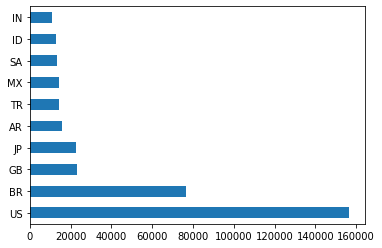

In [3]:
import pandas as pd
df1 = pd.read_csv('final.csv', encoding='utf-8')
df1['country_code'].value_counts().plot(kind='barh')

In [4]:
df1['country_code'].value_counts()

US    156271
BR     76454
GB     23311
JP     22862
AR     15868
TR     14534
MX     14330
SA     13261
ID     12967
IN     10892
Name: country_code, dtype: int64

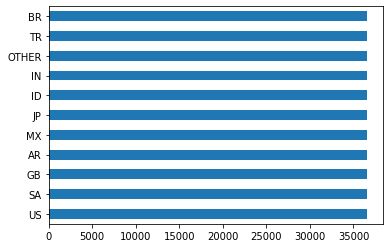

In [31]:
# df2 = pd.read_csv('DAEN_Dataset.csv', encoding='utf-8')
# df2['country_code'].value_counts()
# df2['country_code'].value_counts().plot(kind='barh')

result['country_code'].value_counts().plot(kind='barh')

# Predictive Model

## Data Normalization

In [2]:
import pandas as pd
df = pd.read_csv('11 countries.csv', encoding='utf-8')

In [3]:
df['country_code'].value_counts()

OTHER    36601
IN       36601
TR       36601
US       36601
GB       36601
AR       36601
JP       36601
MX       36601
SA       36601
ID       36601
BR       36601
Name: country_code, dtype: int64

In [25]:
df

,tweet,country_code,bounding_box,screen_name,favourites_count,followers_count,statuses_count,friends_count,listed_count,image_url,banner_url,centroid,country_name
0,"Skin trial doang belagu sia,\nDah ah cape mo s...",ID,"[[[107.666224, -6.938641], [107.666224, -6.904...",bangsadpeople,3202.0,636.0,4754.0,442.0,1.0,https://pbs.twimg.com/profile_images/130582291...,https://pbs.twimg.com/profile_banners/10518289...,"(-6.921403, 107.67888099999999)",Indonesia
1,@Pitty É como você já dizia na letra genial de...,BR,"[[[-48.285982, -16.052405], [-48.285982, -15.5...",HugsOfPoetry,9110.0,171.0,5648.0,597.0,0.0,https://pbs.twimg.com/profile_images/128967808...,https://pbs.twimg.com/profile_banners/10595783...,"(-15.776254, -47.796623000000004)",Brazil
2,@ruhsuzkarbonat Yapacak bişi yok...daha iyilerine,TR,"[[[28.632104, 40.802734], [28.632104, 41.23990...",papillonhero,1937.0,236.0,2555.0,601.0,0.0,https://pbs.twimg.com/profile_images/127750686...,https://pbs.twimg.com/profile_banners/78716328...,"(41.0213205, 29.005222500000002)",Turkey
3,"""Samay"" aur ""shabd"" dono ka upayog laparvahee ...",IN,"[[[86.054331, 19.850414], [86.054331, 19.90745...",abhi_kumar_pth,279.0,7.0,56.0,23.0,0.0,https://pbs.twimg.com/profile_images/125880954...,https://pbs.twimg.com/profile_banners/12575068...,"(19.878935, 86.08442550000001)",India
4,ان الله لا يخيب عبدا تفائل به خيرا💙 https://t....,SA,"[[[46.304398, 24.332068], [46.304398, 25.11181...",M30000o,2.0,5337.0,696.0,218.0,3.0,https://pbs.twimg.com/profile_images/119581213...,https://pbs.twimg.com/profile_banners/11958119...,"(24.721943500000002, 46.685077)",Saudi Arabia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402607,#비대면 #온라인 #집콕\n#말씀 #진리의성읍 #신천지 \n#예수교회 #안드레지파...,OTHER,"[[[129.047809, 35.207935], [129.047809, 35.304...",wjghyunsuk,21044.0,4056.0,80204.0,4732.0,12.0,https://pbs.twimg.com/profile_images/130542104...,https://pbs.twimg.com/profile_banners/99442581...,"(35.256326, 129.09772900000002)",Other Countries
402608,"@sanottomas Pero habrá otros, mejores incluso...",OTHER,"[[[-3.889005, 40.312071], [-3.889005, 40.64351...",juanluistena,30487.0,1974.0,26908.0,912.0,37.0,https://pbs.twimg.com/profile_images/125192616...,https://pbs.twimg.com/profile_banners/23359287...,"(40.4777945, -3.7035075)",Other Countries
402609,Tout compte fait je veux plus la play5,OTHER,"[[[6.583859, 46.45497], [6.583859, 46.60256], ...",AraiaBana,946.0,193.0,3521.0,184.0,0.0,https://pbs.twimg.com/profile_images/130779334...,https://pbs.twimg.com/profile_banners/31612734...,"(46.528765, 6.6523585)",Other Countries
402610,@whosthatludo Le ba bangwe ba ba tshwanang le ...,OTHER,"[[[32.997691, 3.404962], [32.997691, 14.894214...",bamemodungwa,11938.0,807.0,8340.0,982.0,21.0,https://pbs.twimg.com/profile_images/126975552...,https://pbs.twimg.com/profile_banners/13875009...,"(9.149588, 40.498584)",Other Countries


In [7]:
df.dtypes

tweet                object
country_code         object
bounding_box         object
screen_name          object
favourites_count    float64
followers_count     float64
statuses_count      float64
friends_count       float64
listed_count        float64
image_url            object
banner_url           object
centroid             object
country_name         object
dtype: object

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

data = pd.read_csv('11 countries.csv', encoding='utf-8')

# log1p normalization
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for c in [c for c in data.columns if data[c].dtype in numerics]:
    data[c] = np.log1p(data[c])

# min-max normalization
column_names_to_normalize = ['favourites_count','followers_count','statuses_count','friends_count','listed_count']
x = data[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = data.index)
data[column_names_to_normalize] = df_temp

data.head()

# data normalization
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# for c in [c for c in df.columns if df[c].dtype in numerics]:
#     df[c] = np.log1p(df[c]) #log

# df1 = df[['favourites_count','followers_count','statuses_count','friends_count','listed_count']]
# for m in [m for m in df.columns if df[c].dytype in numerics]:  
#     x = df[m].values #returns a numpy array
#     min_max_scaler = preprocessing.MinMaxScaler()
#     x_scaled = min_max_scaler.fit_transform(x)
#     df[m] = pd.DataFrame(x_scaled)

In [13]:
# df

,tweet,country_code,bounding_box,screen_name,favourites_count,followers_count,statuses_count,friends_count,listed_count,image_url,banner_url,centroid,country_name
0,"Skin trial doang belagu sia,\nDah ah cape mo s...",ID,"[[[107.666224, -6.938641], [107.666224, -6.904...",bangsadpeople,8.071843,6.456770,8.466952,6.093570,0.693147,https://pbs.twimg.com/profile_images/130582291...,https://pbs.twimg.com/profile_banners/10518289...,"(-6.921403, 107.67888099999999)",Indonesia
1,@Pitty É como você já dizia na letra genial de...,BR,"[[[-48.285982, -16.052405], [-48.285982, -15.5...",HugsOfPoetry,9.117238,5.147494,8.639234,6.393591,0.000000,https://pbs.twimg.com/profile_images/128967808...,https://pbs.twimg.com/profile_banners/10595783...,"(-15.776254, -47.796623000000004)",Brazil
2,@ruhsuzkarbonat Yapacak bişi yok...daha iyilerine,TR,"[[[28.632104, 40.802734], [28.632104, 41.23990...",papillonhero,7.569412,5.468060,7.846199,6.400257,0.000000,https://pbs.twimg.com/profile_images/127750686...,https://pbs.twimg.com/profile_banners/78716328...,"(41.0213205, 29.005222500000002)",Turkey
3,"""Samay"" aur ""shabd"" dono ka upayog laparvahee ...",IN,"[[[86.054331, 19.850414], [86.054331, 19.90745...",abhi_kumar_pth,5.634790,2.079442,4.043051,3.178054,0.000000,https://pbs.twimg.com/profile_images/125880954...,https://pbs.twimg.com/profile_banners/12575068...,"(19.878935, 86.08442550000001)",India
4,ان الله لا يخيب عبدا تفائل به خيرا💙 https://t....,SA,"[[[46.304398, 24.332068], [46.304398, 25.11181...",M30000o,1.098612,8.582606,6.546785,5.389072,1.386294,https://pbs.twimg.com/profile_images/119581213...,https://pbs.twimg.com/profile_banners/11958119...,"(24.721943500000002, 46.685077)",Saudi Arabia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402607,#비대면 #온라인 #집콕\n#말씀 #진리의성읍 #신천지 \n#예수교회 #안드레지파...,OTHER,"[[[129.047809, 35.207935], [129.047809, 35.304...",wjghyunsuk,9.954418,8.308199,11.292341,8.462315,2.564949,https://pbs.twimg.com/profile_images/130542104...,https://pbs.twimg.com/profile_banners/99442581...,"(35.256326, 129.09772900000002)",Other Countries
402608,"@sanottomas Pero habrá otros, mejores incluso...",OTHER,"[[[-3.889005, 40.312071], [-3.889005, 40.64351...",juanluistena,10.325088,7.588324,10.200216,6.816736,3.637586,https://pbs.twimg.com/profile_images/125192616...,https://pbs.twimg.com/profile_banners/23359287...,"(40.4777945, -3.7035075)",Other Countries
402609,Tout compte fait je veux plus la play5,OTHER,"[[[6.583859, 46.45497], [6.583859, 46.60256], ...",AraiaBana,6.853299,5.267858,8.166784,5.220356,0.000000,https://pbs.twimg.com/profile_images/130779334...,https://pbs.twimg.com/profile_banners/31612734...,"(46.528765, 6.6523585)",Other Countries
402610,@whosthatludo Le ba bangwe ba ba tshwanang le ...,OTHER,"[[[32.997691, 3.404962], [32.997691, 14.894214...",bamemodungwa,9.387566,6.694562,9.028938,6.890609,3.091042,https://pbs.twimg.com/profile_images/126975552...,https://pbs.twimg.com/profile_banners/13875009...,"(9.149588, 40.498584)",Other Countries


In [14]:
# df1.columns=['favourites_count','followers_count','statuses_count','friends_count','listed_count']
# df1
# column_names_to_normalize = ['favourites_count','followers_count','statuses_count','friends_count','listed_count']
# x = df[column_names_to_normalize].values
# x_scaled = min_max_scaler.fit_transform(x)
# df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
# df[column_names_to_normalize] = df_temp

In [15]:
# df.update(df1)
df

,tweet,country_code,bounding_box,screen_name,favourites_count,followers_count,statuses_count,friends_count,listed_count,image_url,banner_url,centroid,country_name
0,"Skin trial doang belagu sia,\nDah ah cape mo s...",ID,"[[[107.666224, -6.938641], [107.666224, -6.904...",bangsadpeople,0.572163,0.361086,0.558001,0.429112,0.060945,https://pbs.twimg.com/profile_images/130582291...,https://pbs.twimg.com/profile_banners/10518289...,"(-6.921403, 107.67888099999999)",Indonesia
1,@Pitty É como você já dizia na letra genial de...,BR,"[[[-48.285982, -16.052405], [-48.285982, -15.5...",HugsOfPoetry,0.646264,0.287867,0.570367,0.450240,0.000000,https://pbs.twimg.com/profile_images/128967808...,https://pbs.twimg.com/profile_banners/10595783...,"(-15.776254, -47.796623000000004)",Brazil
2,@ruhsuzkarbonat Yapacak bişi yok...daha iyilerine,TR,"[[[28.632104, 40.802734], [28.632104, 41.23990...",papillonhero,0.536549,0.305794,0.513443,0.450710,0.000000,https://pbs.twimg.com/profile_images/127750686...,https://pbs.twimg.com/profile_banners/78716328...,"(41.0213205, 29.005222500000002)",Turkey
3,"""Samay"" aur ""shabd"" dono ka upayog laparvahee ...",IN,"[[[86.054331, 19.850414], [86.054331, 19.90745...",abhi_kumar_pth,0.399415,0.116290,0.240455,0.223800,0.000000,https://pbs.twimg.com/profile_images/125880954...,https://pbs.twimg.com/profile_banners/12575068...,"(19.878935, 86.08442550000001)",India
4,ان الله لا يخيب عبدا تفائل به خيرا💙 https://t....,SA,"[[[46.304398, 24.332068], [46.304398, 25.11181...",M30000o,0.077874,0.479971,0.420172,0.379501,0.121889,https://pbs.twimg.com/profile_images/119581213...,https://pbs.twimg.com/profile_banners/11958119...,"(24.721943500000002, 46.685077)",Saudi Arabia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402607,#비대면 #온라인 #집콕\n#말씀 #진리의성읍 #신천지 \n#예수교회 #안드레지파...,OTHER,"[[[129.047809, 35.207935], [129.047809, 35.304...",wjghyunsuk,0.705607,0.464625,0.760806,0.595921,0.225522,https://pbs.twimg.com/profile_images/130542104...,https://pbs.twimg.com/profile_banners/99442581...,"(35.256326, 129.09772900000002)",Other Countries
402608,"@sanottomas Pero habrá otros, mejores incluso...",OTHER,"[[[-3.889005, 40.312071], [-3.889005, 40.64351...",juanluistena,0.731881,0.424367,0.682414,0.480038,0.319832,https://pbs.twimg.com/profile_images/125192616...,https://pbs.twimg.com/profile_banners/23359287...,"(40.4777945, -3.7035075)",Other Countries
402609,Tout compte fait je veux plus la play5,OTHER,"[[[6.583859, 46.45497], [6.583859, 46.60256], ...",AraiaBana,0.485788,0.294598,0.536455,0.367620,0.000000,https://pbs.twimg.com/profile_images/130779334...,https://pbs.twimg.com/profile_banners/31612734...,"(46.528765, 6.6523585)",Other Countries
402610,@whosthatludo Le ba bangwe ba ba tshwanang le ...,OTHER,"[[[32.997691, 3.404962], [32.997691, 14.894214...",bamemodungwa,0.665426,0.374384,0.598340,0.485240,0.271778,https://pbs.twimg.com/profile_images/126975552...,https://pbs.twimg.com/profile_banners/13875009...,"(9.149588, 40.498584)",Other Countries


In [38]:
df.to_csv(r'Normalized_data.csv',index = False,header = True)

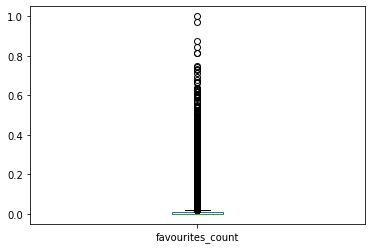

In [39]:
df['favourites_count'].plot.box()

# Check whether urls have valid images

In [1]:
import pandas as pd
data = pd.read_csv('11 countries.csv', encoding='utf-8')

In [19]:
data['image_url'].iloc[66]

'https://pbs.twimg.com/profile_images/1195682723463094273/B6I8h0Gt.jpg'

In [2]:
import requests

#data1 = data.head(5)

url_lines = data['image_url']

image_code = []

for url in url_lines:
    remove_url = requests.get(url)
    image_code.append(remove_url.status_code)



SSLError: HTTPSConnectionPool(host='pbs.twimg.com', port=443): Max retries exceeded with url: /profile_images/1308469414619238400/28Q4Dlhc.jpg (Caused by SSLError(SSLError("bad handshake: SysCallError(54, 'ECONNRESET')")))

In [ ]:
# data1.drop(data1[data1['image_url'] < 25].index, inplace = True) 

In [35]:
image_code

[404, 200, 200, 200, 200]

In [ ]:
url_lines1 = data['banner_url']

banner_code = []

for url in url_lines1:
    remove_url1 = requests.get(url)
    banner_code.append(remove_url1.status_code)



In [ ]:
banner_code

In [5]:
data.head(10000)['country_code'].value_counts()

US    4147
BR    2377
GB     967
TR     510
IN     490
AR     354
SA     354
ID     319
MX     311
JP     171
Name: country_code, dtype: int64